# Import packages

In [151]:
import numpy as np
import pandas as pd
from itertools import chain
from pprint import pprint
from collections import Counter
from datetime import datetime, date, timedelta

import sqlite3
from pathlib import Path
import yaml
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.colors as mcolors

In [2]:
#Topic modeling with LDA
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#For interactive graph:
import pyLDAvis.gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\U060419\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#network
import networkx as nx

# Read data

In [14]:
path = Path('C:/Users/U060419/UCB/iPVU Web Scraping and trends - General/articles.db')

In [25]:
conn = sqlite3.connect('articles.db')
pd.read_sql("select name from sqlite_master where type = 'table'",conn)

,name
0,articles_all
1,articles_unique


In [26]:
data = pd.read_sql("SELECT * FROM articles_unique",conn)
data.head()

,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words
0,DOI:10.1016/j.ando.2020.04.005,10.1016/j.ando.2020.04.005,Annales d'Endocrinologie,2020-04-21 00:00:00+00:00,ELSEVIER,"['renin-angiotensin-aldosterone', 'system', 'c...",['Abstract With multiplication COVID-19 severe...,"['abstract', 'with', 'multiplication', 'covid-..."
1,DOI:10.1016/j.jamda.2020.04.017,10.1016/j.jamda.2020.04.017,Journal of the American Medical Directors Asso...,2020-04-23 00:00:00+00:00,ELSEVIER,"['the', 'geriatrician', 'the', 'frontline', 's...","['Abstract On February 20 , 2020 , man live no...","['abstract', 'on', 'february', '20', '2020', '..."
2,DOI:10.1016/j.fertnstert.2020.04.025,10.1016/j.fertnstert.2020.04.025,Fertility and Sterility,2020-04-16 00:00:00+00:00,ELSEVIER,"['prior', 'novel', 'coronaviruses', 'covid-19'...",['Structured Abstract Objective To summarize c...,"['structured', 'abstract', 'objective', 'to', ..."
3,DOI:10.1016/j.neurol.2020.04.004,10.1016/j.neurol.2020.04.004,Revue Neurologique,2020-04-20 00:00:00+00:00,ELSEVIER,"['guidance', 'care', 'neuromuscular', 'patient...","['Abstract In France , epidemic phase COVID-19...","['abstract', 'in', 'france', 'epidemic', 'phas..."
4,DOI:10.1016/j.jtcvs.2020.04.059,10.1016/j.jtcvs.2020.04.059,The Journal of Thoracic and Cardiovascular Sur...,2020-04-27 00:00:00+00:00,ELSEVIER,"['adult', 'cardiac', 'surgery', 'covid-19', 'p...",['Abstract The COVID-19 pandemic necessitate a...,"['abstract', 'the', 'covid-19', 'pandemic', 'n..."


In [16]:
#data = pd.read_sql("SELECT * FROM articles_all",conn)
#data.head()

,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words
0,DOI:10.1016/j.ando.2020.04.005,10.1016/j.ando.2020.04.005,Annales d'Endocrinologie,2020-04-21 00:00:00+00:00,ELSEVIER,"['renin-angiotensin-aldosterone', 'system', 'c...",['Abstract With multiplication COVID-19 severe...,"['abstract', 'with', 'multiplication', 'covid-..."
1,DOI:10.1016/j.jamda.2020.04.017,10.1016/j.jamda.2020.04.017,Journal of the American Medical Directors Asso...,2020-04-23 00:00:00+00:00,ELSEVIER,"['the', 'geriatrician', 'the', 'frontline', 's...","['Abstract On February 20 , 2020 , man live no...","['abstract', 'on', 'february', '20', '2020', '..."
2,DOI:10.1016/j.fertnstert.2020.04.025,10.1016/j.fertnstert.2020.04.025,Fertility and Sterility,2020-04-16 00:00:00+00:00,ELSEVIER,"['prior', 'novel', 'coronaviruses', 'covid-19'...",['Structured Abstract Objective To summarize c...,"['structured', 'abstract', 'objective', 'to', ..."
3,DOI:10.1016/j.neurol.2020.04.004,10.1016/j.neurol.2020.04.004,Revue Neurologique,2020-04-20 00:00:00+00:00,ELSEVIER,"['guidance', 'care', 'neuromuscular', 'patient...","['Abstract In France , epidemic phase COVID-19...","['abstract', 'in', 'france', 'epidemic', 'phas..."
4,DOI:10.1016/j.jtcvs.2020.04.059,10.1016/j.jtcvs.2020.04.059,The Journal of Thoracic and Cardiovascular Sur...,2020-04-27 00:00:00+00:00,ELSEVIER,"['adult', 'cardiac', 'surgery', 'covid-19', 'p...",['Abstract The COVID-19 pandemic necessitate a...,"['abstract', 'the', 'covid-19', 'pandemic', 'n..."


In [17]:
stop_words = stopwords.words('english')

In [18]:
with open(r'C:/Users/U060419/UCB/iPVU Web Scraping and trends - General/parameters.yml') as file:
    parameters = yaml.full_load(file)
    for param, values in parameters.items():
        print(param, ":", values)
    keywords = parameters.get('keywords')
    keywords.sort()
    stop_words.extend(parameters.get('stopwords'))
    stems = parameters.get('stems')

for keyword in keywords:
    keyword = keyword.strip()
    
for stopword in stop_words:
    stopword = stopword.strip()
    
for stem in stems:
    stem = stem.strip()

keywords : ['brodalumab', 'ixekizumab', 'secukinumab', 'ustekinumab', 'guselkumab', 'risankizumab', 'tildrakizumab', 'brivaracetam', 'romosozumab', 'tocilizumab', 'tofacitinib', 'rituximab', 'golimumab', 'baracitinibs', 'adalimumab', 'apremilast', 'etanercept', 'upadacitinib', 'abatacept', 'infliximab', 'certolizumab', 'methotrexate', 'mofetil', 'azathioprine', 'cyclophosphamide', 'chloroquine', 'tacrolimus', 'ciclosporin', 'global health emergency', 'hydroxychloroquine', 'leflunomide', 'infection', 'sulfasalazine', 'sars-cov-2', 'vitro', 'safety', 'psoriasis', 'arthritis', 'spondylitis', 'crohn', 'il-inhibitor', 'anti-tnf', 'jak', 'bdmards']
stopwords : ['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'abstract', 's

In [27]:
#close connection
conn.close()

# Visualizations

## Number of publications per source

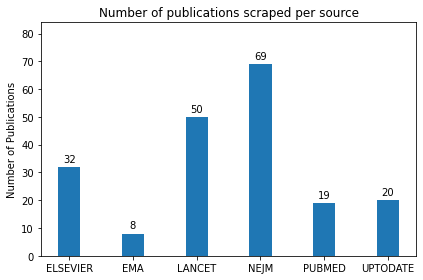

In [28]:
# TO DO - rewrite query for mydate
mydata = data.groupby(['Source']).count()
sources = mydata.index
counts = mydata.title_words

x = np.arange(len(sources))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, counts, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Publications')
ax.set_title('Number of publications scraped per source')
ax.set_xticks(x)
ax.set_xticklabels(sources)
ax.set_ylim([0, max(counts)+15])
# ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

fig.tight_layout()

plt.show()

## Wordcloud per publication

In [93]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      197 non-null    object
 1   DOI                     169 non-null    object
 2   Type                    196 non-null    object
 3   PublishedDate           143 non-null    object
 4   Source                  198 non-null    object
 5   title_words             198 non-null    object
 6   abstract_sentences      197 non-null    object
 7   abstract_words          198 non-null    object
 8   abstract_words_stemmed  197 non-null    object
dtypes: object(9)
memory usage: 14.0+ KB
None


In [131]:
# TO DO: rewrite query + include title (or include title if publication is missing)
data_processed = data[['ID','PublishedDate','abstract_words']]
print('Number of missing values in publishedDate and/or abstract:\n'+str(data_processed.isna().sum()))
# data_ready_with_publicationDate.dropna(inplace=True)

data_processed['text_without_sw'] = data_processed.apply(lambda row: [word for word in ast.literal_eval(row['abstract_words']) if word not in stop_words],
                                                         axis=1)
data_processed.head()

Number of missing values in publishedDate and/or abstract:
ID                 1
PublishedDate     55
abstract_words     0
dtype: int64


c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,ID,PublishedDate,abstract_words,text_without_sw
0,DOI:10.1016/j.ando.2020.04.005,2020-04-21 00:00:00+00:00,"['abstract', 'with', 'multiplication', 'covid-...","[multiplication, covid-19, severe, acute, resp..."
1,DOI:10.1016/j.jamda.2020.04.017,2020-04-23 00:00:00+00:00,"['abstract', 'on', 'february', '20', '2020', '...","[february, 20, 2020, man, live, north, italy, ..."
2,DOI:10.1016/j.fertnstert.2020.04.025,2020-04-16 00:00:00+00:00,"['structured', 'abstract', 'objective', 'to', ...","[objective, summarize, current, understand, ef..."
3,DOI:10.1016/j.neurol.2020.04.004,2020-04-20 00:00:00+00:00,"['abstract', 'in', 'france', 'epidemic', 'phas...","[france, epidemic, phase, covid-19, cause, sev..."
4,DOI:10.1016/j.jtcvs.2020.04.059,2020-04-27 00:00:00+00:00,"['abstract', 'the', 'covid-19', 'pandemic', 'n...","[covid-19, pandemic, necessitate, aggressive, ..."


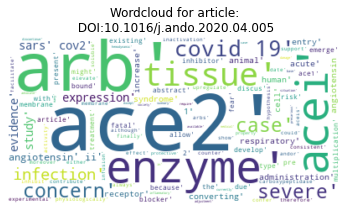

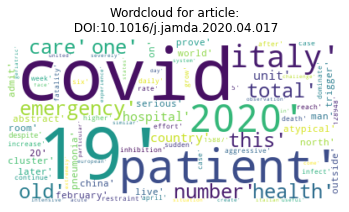

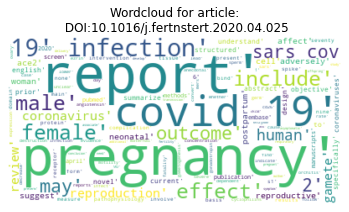

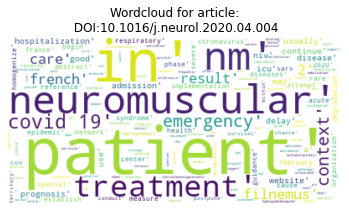

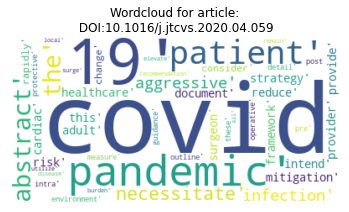

In [132]:
#TO DO: extract title instead of ID
#First 5 publications

for ID in data_processed[0:5]['ID']:
    publ = data_processed[data_processed['ID'] == ID]
    text = ' '.join([str(word) for word in publ['abstract_words']]) 

    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Wordcloud for article:\n'+publ['ID'].to_string(index=False))
    plt.axis("off")
    plt.show()

## Keyword count for top 5 per publication (bar chart)

In [133]:
def try_parsing_date(text):
    if text == None:
        return None
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S+00:00', '%Y-%m-%d'):
        try:
            return datetime.strptime(text, fmt).date()
        except ValueError:
            pass
    raise ValueError('no valid date format found')

data_processed['PublishedDate'] = data_processed['PublishedDate'].apply(lambda x: try_parsing_date(x))

c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
for ID in data_processed['ID']:
    publ = data_processed[data_processed['ID'] == ID]
    words = publ['abstract_words']
    words = [stems[word] if word in stems.keys() else word for word in words]
    data_processed.loc[data_processed['ID'] == ID,'abstract_words_stemmed'] = words
data_processed.head()

In [139]:
data_processed['text_stemmed'] = data_processed.apply(
    lambda row: [stems[word] if word in stems.keys() else word for word in row['text_without_sw']], axis=1)
data_processed.head()

c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,PublishedDate,abstract_words,text_without_sw,text_stemmed
0,DOI:10.1016/j.ando.2020.04.005,2020-04-21,"['abstract', 'with', 'multiplication', 'covid-...","[multiplication, covid-19, severe, acute, resp...","[multiplication, covid-19, severe, acute, resp..."
1,DOI:10.1016/j.jamda.2020.04.017,2020-04-23,"['abstract', 'on', 'february', '20', '2020', '...","[february, 20, 2020, man, live, north, italy, ...","[february, 20, 2020, man, live, north, italy, ..."
2,DOI:10.1016/j.fertnstert.2020.04.025,2020-04-16,"['structured', 'abstract', 'objective', 'to', ...","[objective, summarize, current, understand, ef...","[objective, summarize, current, understand, ef..."
3,DOI:10.1016/j.neurol.2020.04.004,2020-04-20,"['abstract', 'in', 'france', 'epidemic', 'phas...","[france, epidemic, phase, covid-19, cause, sev...","[france, epidemic, phase, covid-19, cause, sev..."
4,DOI:10.1016/j.jtcvs.2020.04.059,2020-04-27,"['abstract', 'the', 'covid-19', 'pandemic', 'n...","[covid-19, pandemic, necessitate, aggressive, ...","[covid-19, pandemic, necessitate, aggressive, ..."


In [140]:
data_with_keyword = data_processed
for keyword in keywords:
    data_with_keyword[keyword] = data_with_keyword['text_stemmed'].apply(lambda x: x.count(keyword) if (keyword in x) 
                                                                           else 0)
    
data_with_keyword = data_with_keyword.groupby(['ID'],as_index=True).sum()
print(data_with_keyword)

                                                    abatacept  adalimumab  \
ID                                                                          
DOI:10.1007/s11547-020-01200-3                              0           0   
DOI:10.1016/S0140-6736(14)61202-2                           0           0   
DOI:10.1016/S0140-6736(20)30183-5                           0           0   
DOI:10.1016/S0140-6736(20)30460-8                           0           0   
DOI:10.1016/S0140-6736(20)30566-3                           0           0   
...                                                       ...         ...   
URL:emas-governance-during-covid-19-pandemic                0           0   
URL:guidance-medicine-developers-companies-covi...          0           0   
URL:international-coalition-medicines-regulator...          0           0   
URL:public-health-advice-during-covid-19-pandemic           0           0   
URL:treatments-vaccines-covid-19                            0           0   

c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


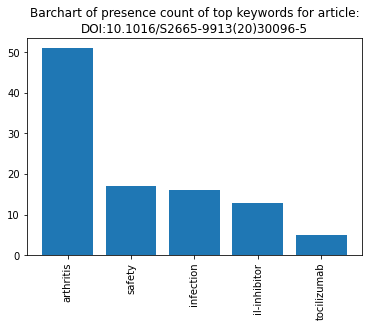

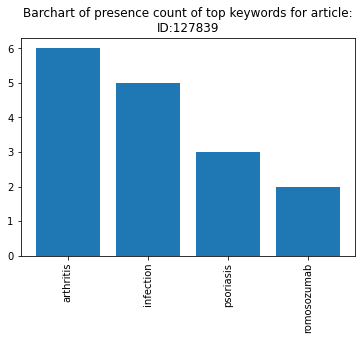

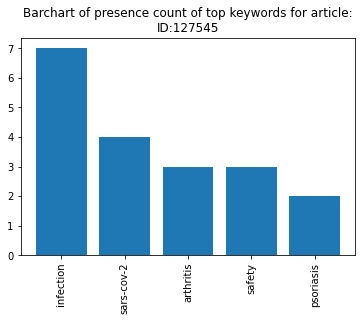

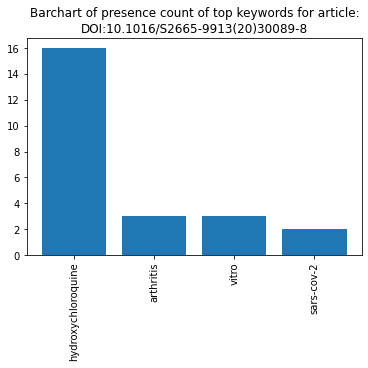

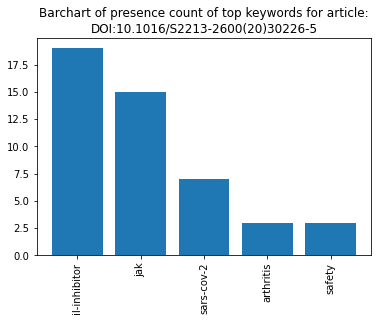

In [141]:
#First 5 publications

data_with_keyword.sort_values(by=keywords, ascending=False, inplace=True)

for ID in data_with_keyword[0:5].index:
    publ = data_with_keyword[data_with_keyword.index == ID]
    cnt = Counter(publ.iloc[:,3:].to_dict('r')[0])
    cnt += Counter()
    top_5 = cnt.most_common(5)  
    if len(top_5) == 0:
        continue
    terms = list(zip(*top_5))[0]
    counts = list(zip(*top_5))[1]
    plt.bar(range(len(counts)), counts, align='center')
    plt.xticks(range(len(terms)), terms)
    plt.title('Barchart of presence count of top keywords for article:\n'+ID)
    plt.xticks(rotation=90)
    plt.show()
    

# Topic model with LDA

In [146]:
data_for_topics = data_processed['text_stemmed']

In [147]:
#Build topic model

#parameters
n_topics = 5 #number of topics

# Create Dictionary
id2word = corpora.Dictionary(data_for_topics)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_for_topics]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#### Topics:

In [148]:
pprint(lda_model.print_topics())

[(0,
  '0.016*"anakinra" + 0.013*"2020" + 0.010*"j" + 0.010*"0" + 0.006*"april" + '
  '0.006*"march" + 0.006*"urlplaceholder" + 0.006*"online" + 0.006*"p" + '
  '0.006*"access"'),
 (1,
  '0.048*"covid-19" + 0.028*"patient" + 0.017*"coronavirus" + 0.014*"care" + '
  '0.012*"infection" + 0.010*"2019" + 0.008*"test" + 0.008*"united" + '
  '0.008*"include" + 0.008*"risk"'),
 (2,
  '0.038*"patient" + 0.027*"disease" + 0.017*"clinical" + 0.013*"syndrome" + '
  '0.012*"management" + 0.011*"treatment" + 0.010*"therapy" + 0.008*"acute" + '
  '0.007*"2019" + 0.007*"cytokine"'),
 (3,
  '0.021*"international" + 0.015*"american" + 0.014*"virus" + 0.013*"treat" + '
  '0.013*"factor" + 0.012*"guidance" + 0.011*"resources" + 0.011*"arthritis" + '
  '0.011*"resource" + 0.010*"group"'),
 (4,
  '0.024*"disease" + 0.017*"health" + 0.015*"cancer" + 0.011*"pandemic" + '
  '0.010*"anesthesia" + 0.009*"contact" + 0.008*"management" + 0.008*"care" + '
  '0.007*"machine" + 0.007*"provide"')]


#### Documents which match the topic the most for each topic:

In [149]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Topic Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_for_topics)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

df_dominant_topic = df_dominant_topic.merge(data, how='left', left_index=True, right_index=True) #merge with abstract on index

for topic in range(n_topics):
    wp = lda_model.show_topic(topic)
    topic_keywords = ", ".join([word for word, prop in wp])
    print('Topic '+str(topic)+':\n')
    print('Keywords in topic: '+topic_keywords)
    display(df_dominant_topic.loc[df_dominant_topic['Dominant_Topic']==topic,:].sort_values(by='Topic_Perc_Contrib', ascending=False).head(5))

Topic 0:

Keywords in topic: anakinra, 2020, j, 0, april, march, urlplaceholder, online, p, access


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words,abstract_words_stemmed
196,196,0.0,0.8000,"anakinra, 2020, j, 0, april, march, urlplaceho...","[j, coll, radiol]",DOI:10.1016/j.jacr.2020.04.025,10.1016/j.jacr.2020.04.025,J Am Coll Radiol,2020-05-04 00:00:00,PUBMED,"['coronavirus', 'disease', '2019', 'covid-19',...",['J Am Coll Radiol'],"['j', 'am', 'coll', 'radiol']","['j', 'am', 'coll', 'radiol']"
191,191,0.0,0.8000,"anakinra, 2020, j, 0, april, march, urlplaceho...","[j, coll, radiol]",DOI:10.1016/j.jacr.2020.04.019,10.1016/j.jacr.2020.04.019,J Am Coll Radiol,2020-05-04 00:00:00,PUBMED,"['touch', 'me', 'not', 'physical', 'distancing...",['J Am Coll Radiol'],"['j', 'am', 'coll', 'radiol']","['j', 'am', 'coll', 'radiol']"
12,12,0.0,0.7369,"anakinra, 2020, j, 0, april, march, urlplaceho...","[rsum, le, de, cet, article, est, de, dtailler...",DOI:10.1016/j.jchirv.2020.04.009,10.1016/j.jchirv.2020.04.009,Journal de Chirurgie Viscérale,2020-04-18 00:00:00+00:00,ELSEVIER,"['gestion', 'de', 'l', 'pidmie', 'de', 'la', '...",['Résumé Le de cet article est de détailler le...,"['rsum', 'le', 'de', 'cet', 'article', 'est', ...","['rsum', 'le', 'de', 'cet', 'article', 'est', ..."
176,176,0.0,0.6890,"anakinra, 2020, j, 0, april, march, urlplaceho...","[read, interest, world, report, impact, corona...",DOI:10.1016/S0140-6736(20)31053-9,10.1016/S0140-6736(20)31053-9,Correspondence,None,LANCET,"['the', 'arrival', 'sars-cov-2', 'venezuela']",['We read interest World Report impact coronav...,"['we', 'read', 'interest', 'world', 'report', ...","['we', 'read', 'interest', 'world', 'report', ..."
42,42,0.0,0.6224,"anakinra, 2020, j, 0, april, march, urlplaceho...","[criticise, nicaragua, response, coronavirus, ...",DOI:10.1016/S2214-109X(20)30218-7,10.1016/S2214-109X(20)30218-7,Correspondence,None,LANCET,"['nicaragua', 's', 'response', 'covid-19']","[""In criticise Nicaragua 's response coronavir...","['in', 'criticise', 'nicaragua', 's', 'respons...","['in', 'criticise', 'nicaragua', 's', 'respons..."


Topic 1:

Keywords in topic: covid-19, patient, coronavirus, care, infection, 2019, test, united, include, risk


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words,abstract_words_stemmed
121,121,1.0,0.9702,"covid-19, patient, coronavirus, care, infectio...","[peripartum, care, woman, covid-19, 39, week, ...",DOI:10.1056/NEJMc2007605,10.1056/NEJMc2007605,Correspondence,2020-04-16 00:00:00,NEJM,"['uncomplicated', 'delivery', 'patient', 'covi...",['The peripartum care woman Covid-19 39 week g...,"['the', 'peripartum', 'care', 'woman', 'covid-...","['the', 'peripartum', 'care', 'woman', 'covid-..."
1,1,1.0,0.9656,"covid-19, patient, coronavirus, care, infectio...","[february, 20, 2020, man, live, north, italy, ...",DOI:10.1016/j.jamda.2020.04.017,10.1016/j.jamda.2020.04.017,Journal of the American Medical Directors Asso...,2020-04-23 00:00:00+00:00,ELSEVIER,"['the', 'geriatrician', 'the', 'frontline', 's...","['Abstract On February 20 , 2020 , man live no...","['abstract', 'on', 'february', '20', '2020', '...","['abstract', 'on', 'february', '20', '2020', '..."
102,102,1.0,0.9355,"covid-19, patient, coronavirus, care, infectio...","[report, investigator, germany, detect, spread...",DOI:10.1056/NEJMc2001468,10.1056/NEJMc2001468,Correspondence,2020-03-05 00:00:00,NEJM,"['2019-ncov', 'transmission', 'asymptomatic', ...","['In report , investigator Germany detect spre...","['in', 'report', 'investigator', 'germany', 'd...","['in', 'report', 'investigator', 'germany', 'd..."
118,118,1.0,0.9211,"covid-19, patient, coronavirus, care, infectio...","[among, 215, pregnant, woman, admit, new, york...",DOI:10.1056/NEJMc2009316,10.1056/NEJMc2009316,Correspondence,2020-04-13 00:00:00,NEJM,"['sars-cov-2', 'testing', 'obstetrical', 'pati...",['Among 215 pregnant woman admit New York hosp...,"['among', '215', 'pregnant', 'woman', 'admit',...","['among', '215', 'pregnant', 'woman', 'admit',..."
87,87,1.0,0.9154,"covid-19, patient, coronavirus, care, infectio...","[report, investigator, wuhan, china, describe,...",DOI:10.1056/NEJMc2005073,10.1056/NEJMc2005073,Correspondence,2020-04-23 00:00:00,NEJM,"['sars-cov-2', 'infection', 'children']","['In report , investigator Wuhan , China , des...","['in', 'report', 'investigator', 'wuhan', 'chi...","['in', 'report', 'investigator', 'wuhan', 'chi..."


Topic 2:

Keywords in topic: patient, disease, clinical, syndrome, management, treatment, therapy, acute, 2019, cytokine


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words,abstract_words_stemmed
11,11,2.0,0.7568,"patient, disease, clinical, syndrome, manageme...","[number, covid-19, patient, increase, dramatic...",DOI:10.1016/j.ijid.2020.04.061,10.1016/j.ijid.2020.04.061,International Journal of Infectious Diseases,2020-04-25 00:00:00+00:00,ELSEVIER,"['mild', 'versus', 'severe', 'covid-19', 'labo...",['Abstract The number COVID-19 patient increas...,"['abstract', 'the', 'number', 'covid-19', 'pat...","['abstract', 'the', 'number', 'covid-19', 'pat..."
92,92,2.0,0.7490,"patient, disease, clinical, syndrome, manageme...","[cohort, patient, severe, covid-19, receive, t...",DOI:10.1056/NEJMoa2007016,10.1056/NEJMoa2007016,Original Article,2020-04-10 00:00:00,NEJM,"['compassionate-use', 'remdesivir', 'severe', ...",['A cohort patient severe Covid-19 receive tre...,"['a', 'cohort', 'patient', 'severe', 'covid-19...","['a', 'cohort', 'patient', 'severe', 'covid-19..."
63,63,2.0,0.7376,"patient, disease, clinical, syndrome, manageme...","[cardiovascular, complication, rapidly, emerge...",DOI:10.1016/S0140-6736(20)30937-5,10.1016/S0140-6736(20)30937-5,Correspondence,None,LANCET,"['endothelial', 'cell', 'infection', 'endothel...",['Cardiovascular complication rapidly emerge k...,"['cardiovascular', 'complication', 'rapidly', ...","['cardiovascular', 'complication', 'rapidly', ..."
106,106,2.0,0.7014,"patient, disease, clinical, syndrome, manageme...","[consecutive, series, 64, patient, covid-19, a...",DOI:10.1056/NEJMc2008597,10.1056/NEJMc2008597,Correspondence,2020-04-15 00:00:00,NEJM,"['neurologic', 'features', 'sars-cov-2', 'infe...",['In consecutive series 64 patient Covid-19 AR...,"['in', 'consecutive', 'series', '64', 'patient...","['in', 'consecutive', 'series', '64', 'patient..."
7,7,2.0,0.6934,"patient, disease, clinical, syndrome, manageme...","[severe, acute, respiratory, syndrome, coronav...",DOI:10.1016/j.ekir.2020.04.001,10.1016/j.ekir.2020.04.001,Kidney International Reports,2020-04-04 00:00:00+00:00,ELSEVIER,"['management', 'patients', 'dialysis', 'with',...",['The severe acute respiratory syndrome corona...,"['the', 'severe', 'acute', 'respiratory', 'syn...","['the', 'severe', 'acute', 'respiratory', 'syn..."


Topic 3:

Keywords in topic: international, american, virus, treat, factor, guidance, resources, arthritis, resource, group


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words,abstract_words_stemmed
28,28,3.0,0.8966,"international, american, virus, treat, factor,...","[ema, endorse, joint, statement, member, inter...",URL:international-coalition-medicines-regulato...,None,Update,2020-04-28 00:00:00,EMA,"['international', 'coalition', 'medicines', 'r...",['EMA endorse joint statement member Internati...,"['ema', 'endorse', 'joint', 'statement', 'memb...","['ema', 'endorse', 'joint', 'statement', 'memb..."
115,115,3.0,0.7136,"international, american, virus, treat, factor,...","[research, letter, investigator, report, stabi...",DOI:10.1056/NEJMc2004973,10.1056/NEJMc2004973,Correspondence,2020-04-16 00:00:00,NEJM,"['aerosol', 'surface', 'stability', 'sars-cov-2']","['In research letter , investigator report sta...","['in', 'research', 'letter', 'investigator', '...","['in', 'research', 'letter', 'investigator', '..."
25,25,3.0,0.6838,"international, american, virus, treat, factor,...","[ema, european, commission, national, competen...",URL:guidance-medicine-developers-companies-cov...,None,Update,2020-05-04 00:00:00,EMA,"['guidance', 'medicine', 'developer', 'company...","['EMA , European Commission national competent...","['ema', 'european', 'commission', 'national', ...","['ema', 'european', 'commission', 'national', ..."
8,8,3.0,0.6000,"international, american, virus, treat, factor,...",[n],DOI:10.1016/j.jaci.2020.04.029,10.1016/j.jaci.2020.04.029,Journal of Allergy and Clinical Immunology,2020-04-29 00:00:00+00:00,ELSEVIER,"['type', 'i', 'ifn', 'immunoprofiling', 'covid...",None,"['n', 'a']","['n', 'a']"
194,194,3.0,0.5999,"international, american, virus, treat, factor,...",[ophthalmology],DOI:10.1016/j.ophtha.2020.04.028,10.1016/j.ophtha.2020.04.028,Ophthalmology,2020-05-04 00:00:00,PUBMED,"['ocular', 'findings', 'proportion', 'conjunct...",['Ophthalmology'],['ophthalmology'],['ophthalmology']


Topic 4:

Keywords in topic: disease, health, cancer, pandemic, anesthesia, contact, management, care, machine, provide


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words,abstract_words_stemmed
85,85,4.0,0.8254,"disease, health, cancer, pandemic, anesthesia,...","[burnout, problem, solve, without, address, is...",DOI:10.1056/NEJMp2003149,10.1056/NEJMp2003149,Perspective,2020-05-01 00:00:00,NEJM,"['physician', 'burnout', 'interrupted']",['The burnout problem ’ solve without address ...,"['the', 'burnout', 'problem', 'solve', 'withou...","['the', 'burnout', 'problem', 'solve', 'withou..."
100,100,4.0,0.8130,"disease, health, cancer, pandemic, anesthesia,...","[emerge, consensus, graduate, approach, covid-...",DOI:10.1056/NEJMp2007637,10.1056/NEJMp2007637,Perspective,2020-04-09 00:00:00,NEJM,"['disease', 'control', 'civil', 'liberties', '...",['There emerge consensus graduate approach Cov...,"['there', 'emerge', 'consensus', 'graduate', '...","['there', 'emerge', 'consensus', 'graduate', '..."
98,98,4.0,0.7978,"disease, health, cancer, pandemic, anesthesia,...","[harvey, fineberg, call, forceful, focus, camp...",DOI:10.1056/NEJMe2007263,10.1056/NEJMe2007263,Editorial,2020-04-23 00:00:00,NEJM,"['ten', 'weeks', 'crush', 'curve']","['Harvey Fineberg call forceful , focus campai...","['harvey', 'fineberg', 'call', 'forceful', 'fo...","['harvey', 'fineberg', 'call', 'forceful', 'fo..."
27,27,4.0,0.6721,"disease, health, cancer, pandemic, anesthesia,...","[ema, provide, update, measure, eu, authority,...",URL:availability-medicines-during-covid-19-pan...,None,Update,2020-04-30 00:00:00,EMA,"['availability', 'medicine', 'covid-19', 'pand...",['EMA provide update measure EU authority put ...,"['ema', 'provide', 'update', 'measure', 'eu', ...","['ema', 'provide', 'update', 'measure', 'eu', ..."
122,122,4.0,0.6600,"disease, health, cancer, pandemic, anesthesia,...","[covid-19, pandemic, spread, continue, plague,...",DOI:10.1056/NEJMp2007466,10.1056/NEJMp2007466,Perspective,2020-04-01 00:00:00,NEJM,"['harnessing', 'our', 'humanity']","['As Covid-19 pandemic spread , ’ continue pla...","['as', 'covid-19', 'pandemic', 'spread', 'cont...","['as', 'covid-19', 'pandemic', 'spread', 'cont..."


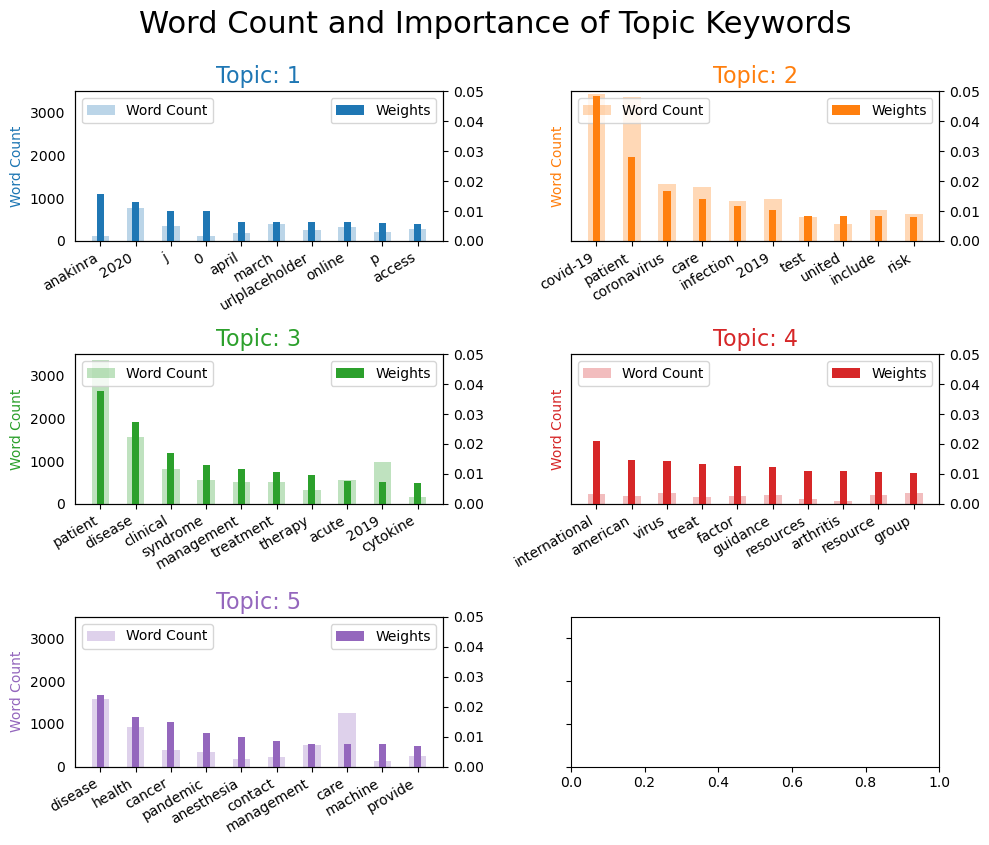

In [152]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_for_topics for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(10,8), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()[0:-1]):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.050); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [153]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.270639  0.087765       1        1  43.878021
2     -0.179859 -0.077965       2        1  24.451763
0      0.172374  0.271636       3        1  13.251758
4      0.083878 -0.159237       4        1  12.930075
3      0.194246 -0.122199       5        1   5.488377, topic_info=               Term         Freq        Total Category  logprob  loglift
34         covid-19  3878.000000  3878.000000  Default  30.0000  30.0000
146         patient  3755.000000  3755.000000  Default  29.0000  29.0000
288         disease  1744.000000  1744.000000  Default  28.0000  28.0000
498        clinical   793.000000   793.000000  Default  27.0000  27.0000
128          health   914.000000   914.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
391  recommendation    44.621452    86.657303   Topic5  -5.3666   2.2388
503            drug    54.992134   152.864197   Topic5  -5.1576   1.8802
498        clinical    77.111763   793.186707   Topic5  -4.8196   0.5717
34         covid-19    58.712891  3878.987793   Topic5  -5.0922  -1.2881
288         disease    49.009960  1744.133789   Topic5  -5.2728  -0.6695

[289 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3023      2  0.060792           0
3023      3  0.940255           0
0         1  0.289262           1
0         2  0.710298           1
4185      3  0.994766        2011
...     ...       ...         ...
4333      4  0.893588  ventilator
563       5  0.995124       virus
485       2  0.989065         vte
260       1  0.998163       woman
934       1  0.995725       wuhan

[368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 4])

# Trends for keywords

In [154]:
data_processed['week'] = data_processed['PublishedDate'].apply(lambda x: x.week() if x != None else None)

AttributeError: 'datetime.date' object has no attribute 'week'

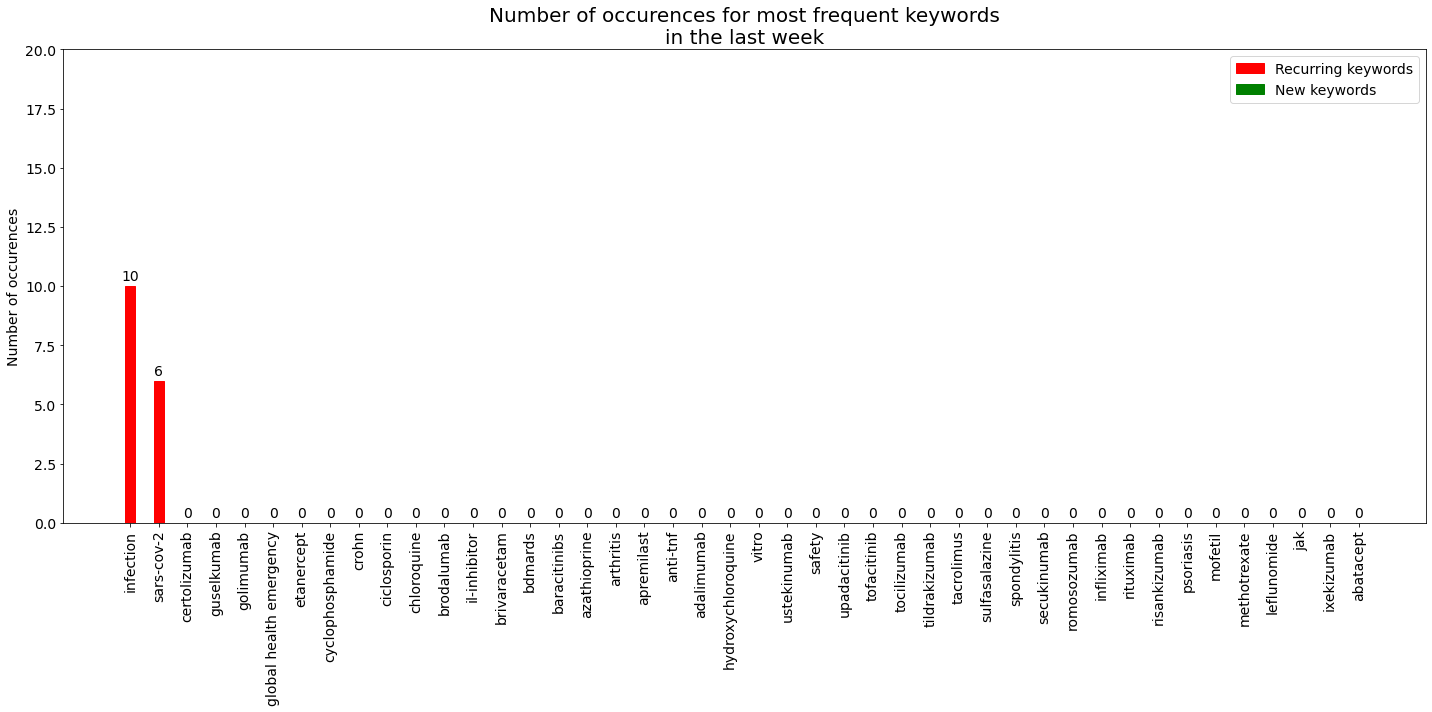

In [104]:
#number of keywords to show:
n = 50

t = (datetime.today() - timedelta(days=7)).date()
after = data_processed[data_processed.PublishedDate >= t]
before = data_processed[data_processed.PublishedDate < t]
after = after.iloc[:,after.columns.get_loc(keywords[0]):].sum()
before = before.iloc[:,before.columns.get_loc(keywords[0]):].sum()
after.sort_values(ascending=False, inplace=True)

recurring_entities = []
for keyword in after.index:
    if keyword in before.index:
        recurring_entities.append(keyword)

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
terms = after.index[0:n]
counts = after[0:n]

x = np.arange(len(terms))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x, counts, width)

for i in range(0,len(terms)):
    if terms[i] in recurring_entities:
        rects1[i].set_color('r')
    else:
        rects1[i].set_color('g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of occurences', fontsize=14)
ax.set_title('Number of occurences for most frequent keywords\nin the last week', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(terms)
ax.set_ylim([0, max(counts)+10])
ax.tick_params(labelsize=14)
plt.xticks(rotation=90) 

red_patch = mpatches.Patch(color='red', label='Recurring keywords')
green_patch = mpatches.Patch(color='green', label='New keywords')
plt.legend(handles=[red_patch,green_patch],fontsize=14)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=14)


autolabel(rects1)

fig.tight_layout()

plt.show()

In [158]:
evolution = data_processed
    
evolution = evolution.groupby(['PublishedDate'],as_index=True)[keywords].sum()
evolution.sort_values(by='PublishedDate', inplace=True)
evolution = evolution.T

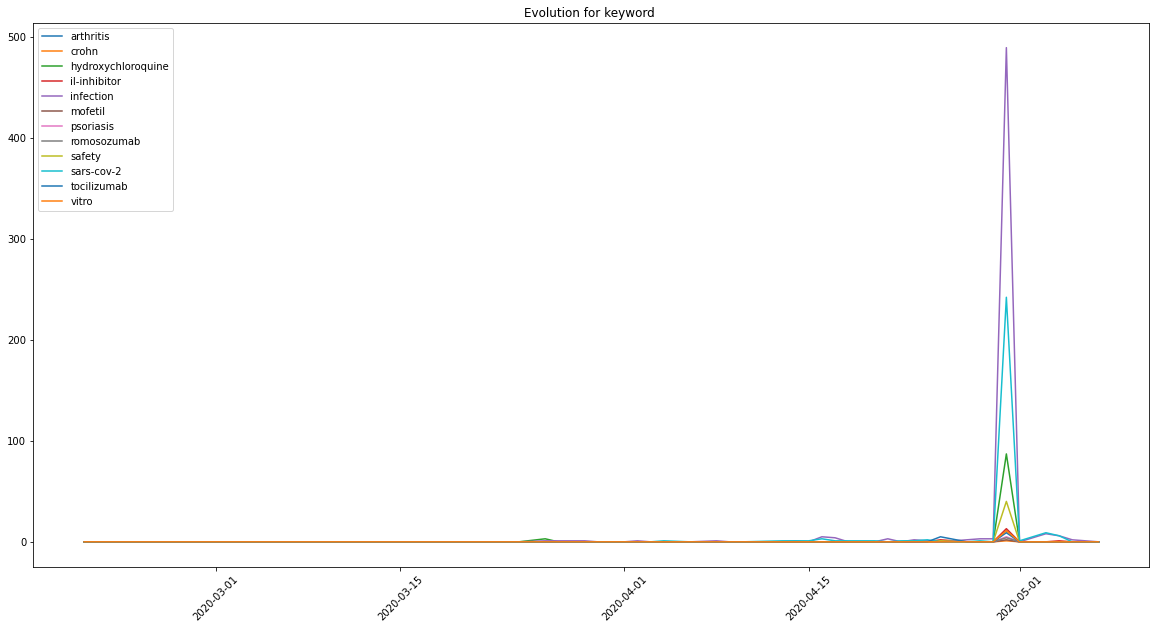

In [159]:
fig, ax = plt.subplots(figsize=(20,10))
l = []
skip_keywords = [] #ADD here keywords to skip in plot

for keyword in keywords:
    if (evolution.loc[evolution.index==keyword,:].sum(axis=1) == 0).all():
        continue
    if keyword in skip_keywords:
        continue
    plt.plot(evolution.columns,evolution[evolution.index==keyword].T)
    plt.xticks(rotation=45)
    plt.title('Evolution for keyword ')
    l.append(keyword)
plt.legend(l)

## Network

In [160]:
adj = data_processed[['ID','text_stemmed']]

for keyword in keywords:
    adj[keyword] = adj['text_stemmed'].apply(lambda x: x.count(keyword) if (keyword in x)
                                                         else 0)
    
adj = adj.groupby(['ID'],as_index=True)[keywords].sum()
adj = adj.T
adj.sort_index(inplace=True)
display(adj.shape)

c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(44, 197)

In [161]:
#adjacency matrix of keywords based on publications
A = np.dot(adj,adj.T)
adj = pd.DataFrame(A, index=adj.index, columns=adj.index)
display(adj[adj>=1])

,abatacept,adalimumab,anti-tnf,apremilast,arthritis,azathioprine,baracitinibs,bdmards,brivaracetam,brodalumab,...,secukinumab,spondylitis,sulfasalazine,tacrolimus,tildrakizumab,tocilizumab,tofacitinib,upadacitinib,ustekinumab,vitro
abatacept,25.0,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN
adalimumab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anti-tnf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apremilast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arthritis,255.0,NaN,NaN,NaN,2672.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,255.0,6.0,NaN,NaN,9.0
azathioprine,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
baracitinibs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bdmards,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brivaracetam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brodalumab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


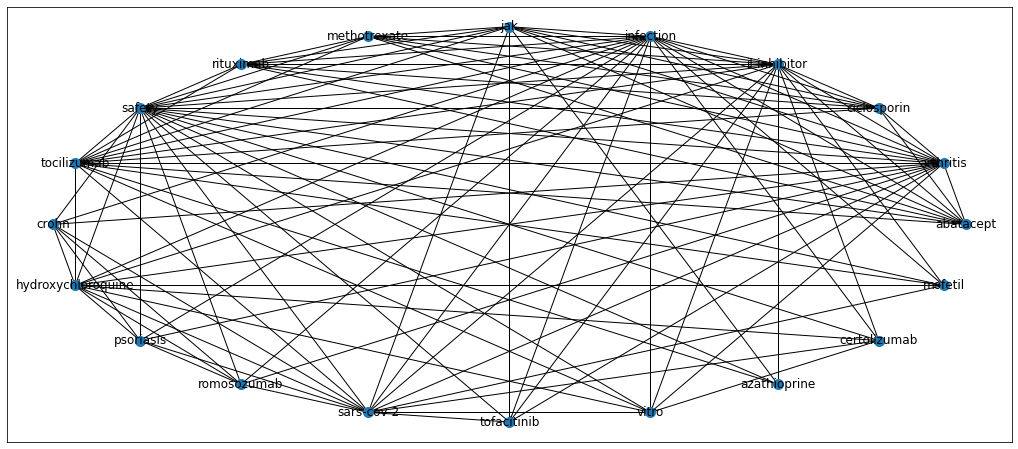

In [162]:
rows, cols = np.where(A >= 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
matching = {x : adj.index.values[x] for x in range(len(adj.index))} 
gr = nx.relabel_nodes(gr,matching)
graph_pos=nx.circular_layout(gr)
plt.figure(figsize=(18,8)) 
nx.draw_networkx_nodes(gr,graph_pos,node_size=100)
nx.draw_networkx_edges(gr,graph_pos)
nx.draw_networkx_labels(gr, graph_pos)
plt.show()
    